# Stock Risk Classification Model

## Objective
Build a machine learning model to predict whether a stock will enter a high-volatility regime in the next 21 trading days. This replaces the manual weighted risk formula with a data-driven approach.

## Approach
1. **Data Collection** — 5 years of daily OHLCV data for 48 tech stocks + SPY benchmark
2. **Feature Engineering** — 34 features: technical indicators, volatility, momentum, cross-sectional ranks, market regime
3. **Target Variable** — Binary: 1 if forward 21-day realized volatility is in the top 30% (high risk)
4. **Model Iteration** — v1 (drawdown target, AUC ~0.56) → v3 (volatility target, AUC 0.73)
5. **Evaluation** — AUC-ROC, precision-recall, calibration, confusion matrix, cross-validation
6. **Export** — Save best model for live application integration

## Key Result
- **Final Model:** XGBoost with 34 features
- **Test AUC-ROC:** 0.73 | **CV AUC:** 0.86 ± 0.025
- **Accuracy:** 70% | **F1 (High Risk):** 0.54

In [43]:
# ============================================================
# 1. IMPORTS & SETUP
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json
import os
from datetime import datetime, timedelta

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, accuracy_score
)
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print('All imports successful.')

All imports successful.


---
## 2. Data Collection

We fetch 5 years of daily OHLCV data for our tech stock universe from Yahoo Finance. We also download S&P 500 (SPY) for beta calculation and market regime features.

In [44]:
# Stock universe (same as our platform)
SYMBOLS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'NFLX',
    'ADBE', 'CRM', 'ORCL', 'CSCO', 'INTC', 'AMD', 'QCOM', 'TXN',
    'AVGO', 'INTU', 'AMAT', 'LRCX', 'MU', 'KLAC', 'SNPS', 'CDNS',
    'MCHP', 'MRVL', 'NXPI', 'ADI', 'SWKS', 'QRVO', 'UBER', 'ABNB',
    'SNOW', 'ZM', 'DOCU', 'SHOP', 'COIN', 'RBLX', 'DDOG', 'NET',
    'CRWD', 'ZS', 'PANW', 'FTNT', 'OKTA', 'NOW', 'WDAY', 'TEAM',
]

ALL_TICKERS = SYMBOLS + ['SPY']

print(f'Downloading 5 years of data for {len(ALL_TICKERS)} tickers...')
raw_data = yf.download(ALL_TICKERS, period='5y', interval='1d', group_by='ticker', auto_adjust=True)
print(f'Download complete. Shape: {raw_data.shape}')

[*********************100%***********************]  49 of 49 completed

Download complete. Shape: (1255, 245)


In [45]:
# Reshape into clean long-format DataFrame
records = []
for symbol in ALL_TICKERS:
    try:
        df = raw_data[symbol].dropna(subset=['Close'])
        df = df.reset_index()
        df['symbol'] = symbol
        df.columns = [c.lower() if c != 'symbol' else c for c in df.columns]
        records.append(df[['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']])
    except Exception as e:
        print(f'  Skipping {symbol}: {e}')

data = pd.concat(records, ignore_index=True)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['symbol', 'date']).reset_index(drop=True)

print(f'\nTotal records: {len(data):,}')
print(f'Date range: {data.date.min().date()} to {data.date.max().date()}')
print(f'Stocks loaded: {data.symbol.nunique()}')
print(f'\nRecords per stock:')
print(data.groupby('symbol').size().describe())


Total records: 61,443
Date range: 2021-02-18 to 2026-02-17
Stocks loaded: 49

Records per stock:
count      49.000000
mean     1253.938776
std         5.746043
min      1217.000000
25%      1255.000000
50%      1255.000000
75%      1255.000000
max      1255.000000
dtype: float64


In [46]:
# Data quality check
missing = data.isnull().sum()
print('Missing values:')
print(missing[missing > 0] if missing.any() else 'None')

stock_counts = data.groupby('symbol').size()
short_stocks = stock_counts[stock_counts < 500]
if len(short_stocks) > 0:
    print(f'\nStocks with < 500 trading days (IPO within 5yr window):')
    print(short_stocks)

Missing values:
None


---
## 3. Feature Engineering (v1 — 18 Base Features)

| Category | Features | Rationale |
|----------|----------|-----------|
| Volatility | 21d, 63d rolling std | Short and medium-term risk |
| Momentum | 5d, 10d, 21d, 63d returns | Price trend signals |
| RSI | 14-day RSI | Overbought/oversold |
| MACD | Line, signal, histogram | Trend strength |
| Bollinger | Width, %B position | Volatility + mean reversion |
| Volume | Volume ratio (vs 50d avg) | Unusual activity |
| Drawdown | Max drawdown (trailing 63d) | Downside risk history |
| Beta | Rolling 63d beta vs SPY | Systematic risk |
| Price | Distance from 52w high/low | Relative position |
| ATR | Normalized 14-day ATR | Price range volatility |

In [47]:
# Separate SPY for benchmark calculations
spy_data = data[data['symbol'] == 'SPY'][['date', 'close']].rename(columns={'close': 'spy_close'})
spy_data['spy_return'] = spy_data['spy_close'].pct_change()

stock_data = data[data['symbol'] != 'SPY'].copy()
stock_data = stock_data.merge(spy_data[['date', 'spy_return']], on='date', how='left')

print(f'Stock data shape: {stock_data.shape}')
print(f'SPY data shape: {spy_data.shape}')

Stock data shape: (60188, 8)
SPY data shape: (1255, 3)


In [48]:
def compute_features(df):
    """
    Compute 18 base technical features for a single stock.
    Input: DataFrame with [date, open, high, low, close, volume, spy_return]
    """
    df = df.sort_values('date').copy()
    close = df['close']
    high = df['high']
    low = df['low']
    volume = df['volume']
    
    # Daily Returns
    df['daily_return'] = close.pct_change()
    
    # Volatility (annualized)
    df['volatility_21d'] = df['daily_return'].rolling(21).std() * np.sqrt(252)
    df['volatility_63d'] = df['daily_return'].rolling(63).std() * np.sqrt(252)
    
    # Momentum / Returns
    df['return_5d'] = close.pct_change(5)
    df['return_10d'] = close.pct_change(10)
    df['return_21d'] = close.pct_change(21)
    df['return_63d'] = close.pct_change(63)
    
    # RSI (14-day)
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    df['macd_line'] = ema_12 - ema_26
    df['macd_signal'] = df['macd_line'].ewm(span=9, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['macd_signal']
    
    # Bollinger Bands
    sma_20 = close.rolling(20).mean()
    std_20 = close.rolling(20).std()
    bb_upper = sma_20 + 2 * std_20
    bb_lower = sma_20 - 2 * std_20
    df['bb_width'] = (bb_upper - bb_lower) / (sma_20 + 1e-10)
    df['bb_position'] = (close - bb_lower) / (bb_upper - bb_lower + 1e-10)
    
    # Volume Ratio
    df['volume_ratio'] = volume / (volume.rolling(50).mean() + 1e-10)
    
    # Max Drawdown (trailing 63d)
    rolling_max = close.rolling(63, min_periods=1).max()
    drawdown = (close - rolling_max) / (rolling_max + 1e-10)
    df['max_drawdown_63d'] = drawdown.rolling(63, min_periods=1).min()
    
    # Beta vs SPY (rolling 63d)
    cov = df['daily_return'].rolling(63).cov(df['spy_return'])
    var = df['spy_return'].rolling(63).var()
    df['beta_63d'] = cov / (var + 1e-10)
    
    # Distance from 52-week high/low
    high_252 = high.rolling(252, min_periods=63).max()
    low_252 = low.rolling(252, min_periods=63).min()
    df['dist_from_52w_high'] = (close - high_252) / (high_252 + 1e-10)
    df['dist_from_52w_low'] = (close - low_252) / (low_252 + 1e-10)
    
    # ATR (normalized)
    tr = pd.DataFrame({
        'hl': high - low,
        'hc': abs(high - close.shift(1)),
        'lc': abs(low - close.shift(1))
    }).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean() / (close + 1e-10)
    
    return df

print('Computing v1 features...')
featured_dfs = []
for symbol in stock_data['symbol'].unique():
    sdf = stock_data[stock_data['symbol'] == symbol].copy()
    sdf = compute_features(sdf)
    featured_dfs.append(sdf)

featured_data = pd.concat(featured_dfs, ignore_index=True)

feature_cols = [
    'volatility_21d', 'volatility_63d',
    'return_5d', 'return_10d', 'return_21d', 'return_63d',
    'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram',
    'bb_width', 'bb_position', 'volume_ratio',
    'max_drawdown_63d', 'beta_63d',
    'dist_from_52w_high', 'dist_from_52w_low', 'atr_14'
]

print(f'Featured data shape: {featured_data.shape}')
print(f'Base features ({len(feature_cols)}): {feature_cols}')

Computing v1 features...
Featured data shape: (60188, 27)
Base features (18): ['volatility_21d', 'volatility_63d', 'return_5d', 'return_10d', 'return_21d', 'return_63d', 'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bb_width', 'bb_position', 'volume_ratio', 'max_drawdown_63d', 'beta_63d', 'dist_from_52w_high', 'dist_from_52w_low', 'atr_14']


---
## 4. Target Variable v1 — Drawdown Based

**First attempt:** Label = 1 if stock drops >10% at any point in the next 30 trading days.

In [49]:
DRAWDOWN_THRESHOLD = -0.10
FORWARD_DAYS = 30

def create_target_drawdown(df):
    """Target = 1 if stock drops >10% in next 30 trading days."""
    df = df.sort_values('date').copy()
    close = df['close'].values
    n = len(close)
    
    forward_min = np.full(n, np.nan)
    for i in range(n - FORWARD_DAYS):
        forward_min[i] = np.min(close[i+1 : i+1+FORWARD_DAYS])
    
    df['forward_min_close'] = forward_min
    df['forward_drawdown'] = (df['forward_min_close'] - df['close']) / df['close']
    df['target'] = (df['forward_drawdown'] <= DRAWDOWN_THRESHOLD).astype(int)
    return df

print('Creating drawdown target...')
target_dfs = []
for symbol in featured_data['symbol'].unique():
    sdf = featured_data[featured_data['symbol'] == symbol].copy()
    sdf = create_target_drawdown(sdf)
    target_dfs.append(sdf)

model_data = pd.concat(target_dfs, ignore_index=True)
model_data = model_data.dropna(subset=['target'] + feature_cols)

print(f'Dataset shape: {model_data.shape}')
print(f'Target distribution:\n{model_data.target.value_counts()}')
print(f'Positive rate: {model_data.target.mean():.2%}')

Creating drawdown target...
Dataset shape: (57164, 30)
Target distribution:
target
0    37672
1    19492
Name: count, dtype: int64
Positive rate: 34.10%


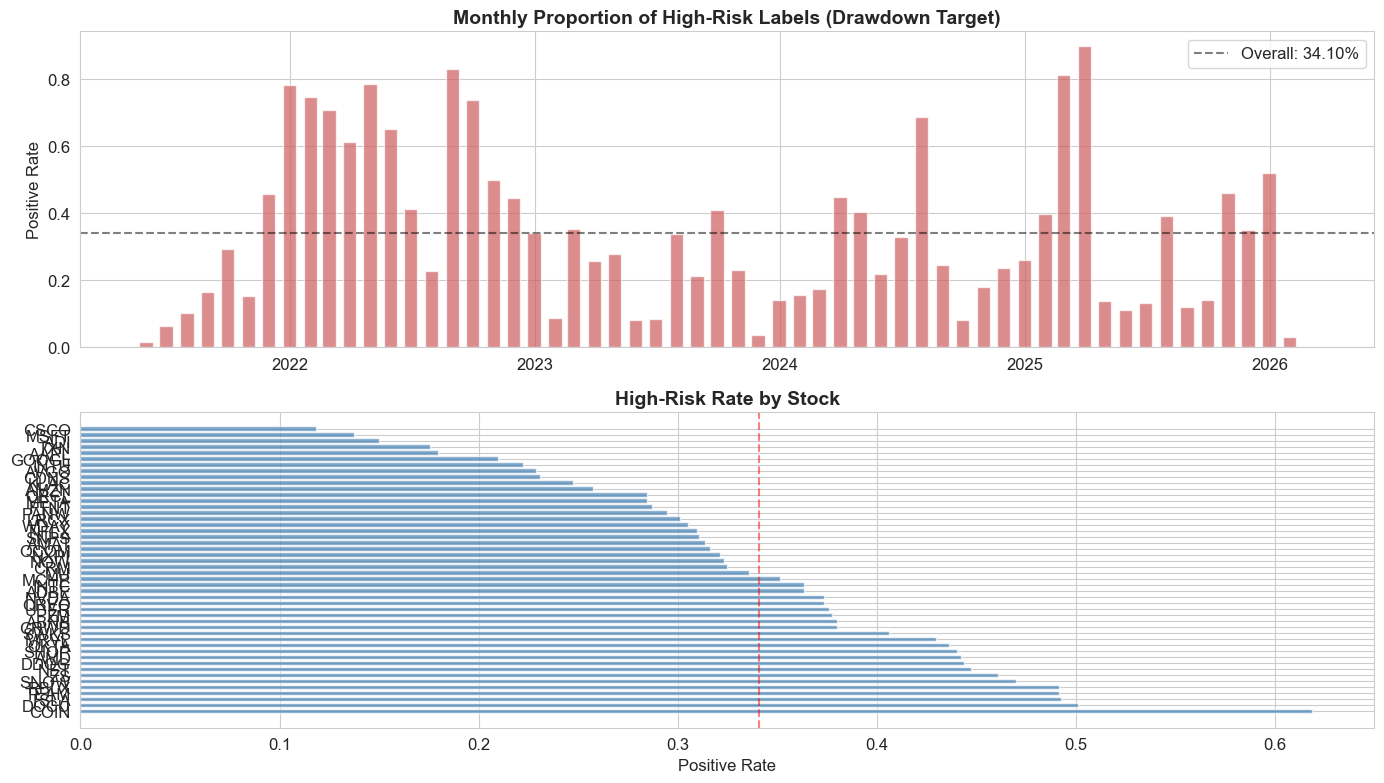

In [50]:
# Target distribution over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

monthly = model_data.set_index('date').groupby(pd.Grouper(freq='M'))['target'].mean()
axes[0].bar(monthly.index, monthly.values, width=20, color='indianred', alpha=0.7)
axes[0].set_title('Monthly Proportion of High-Risk Labels (Drawdown Target)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Positive Rate')
axes[0].axhline(y=model_data.target.mean(), color='black', linestyle='--', alpha=0.5, label=f'Overall: {model_data.target.mean():.2%}')
axes[0].legend()

stock_rates = model_data.groupby('symbol')['target'].mean().sort_values(ascending=False)
axes[1].barh(stock_rates.index, stock_rates.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Positive Rate')
axes[1].set_title('High-Risk Rate by Stock', fontsize=14, fontweight='bold')
axes[1].axvline(x=model_data.target.mean(), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Exploratory Data Analysis

In [51]:
# Feature statistics
print('Feature Statistics:')
model_data[feature_cols].describe().T[['mean', 'std', 'min', '50%', 'max']]

Feature Statistics:


,mean,std,min,50%,max
volatility_21d,0.422419,0.209966,0.088340,0.369133,1.817202
volatility_63d,0.435645,0.178772,0.124408,0.397026,1.559165
return_5d,0.003694,0.065087,-0.587245,0.003372,0.740699
return_10d,0.007074,0.090085,-0.561648,0.005827,0.746980
return_21d,0.014828,0.130403,-0.650874,0.010566,1.424405
return_63d,0.045164,0.222255,-0.760956,0.030737,1.590045
rsi_14,51.855407,17.194181,0.000000,51.647804,100.000000
macd_line,0.494766,6.342755,-55.249654,0.331862,94.709900
macd_signal,0.501660,5.933044,-49.963199,0.311513,79.570637
macd_histogram,-0.006893,1.912445,-35.956048,0.007405,22.753431


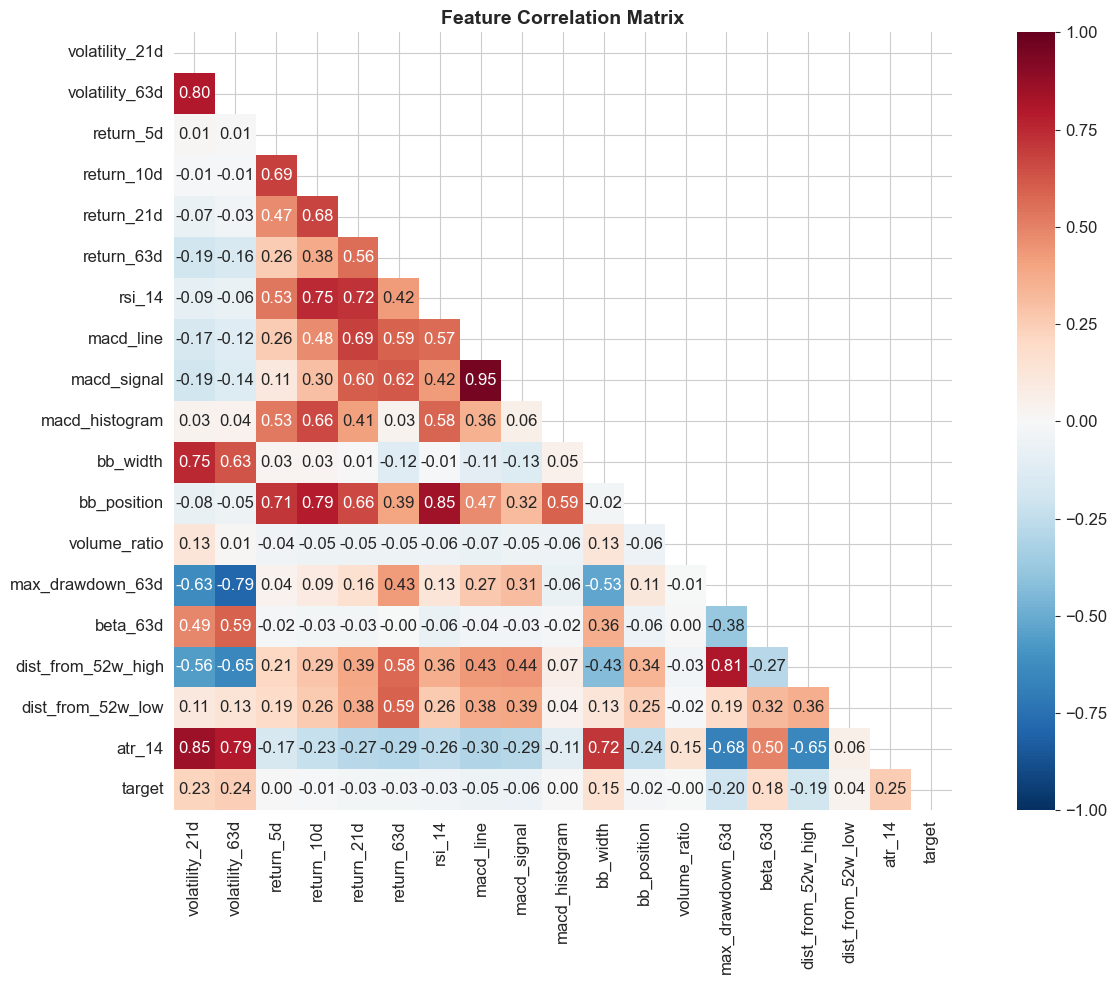


Correlation with target:
atr_14                0.252065
volatility_63d        0.242997
volatility_21d        0.225765
max_drawdown_63d      0.198867
dist_from_52w_high    0.189615
beta_63d              0.183895
bb_width              0.150433
macd_signal           0.057788
macd_line             0.053651
dist_from_52w_low     0.038477
rsi_14                0.031649
return_21d            0.029884
return_63d            0.028664
bb_position           0.016669
return_10d            0.011840
return_5d             0.003696
volume_ratio          0.003094
macd_histogram        0.001342
Name: target, dtype: float64


In [52]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(14, 10))
corr = model_data[feature_cols + ['target']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nCorrelation with target:')
target_corr = corr['target'].drop('target').abs().sort_values(ascending=False)
print(target_corr)

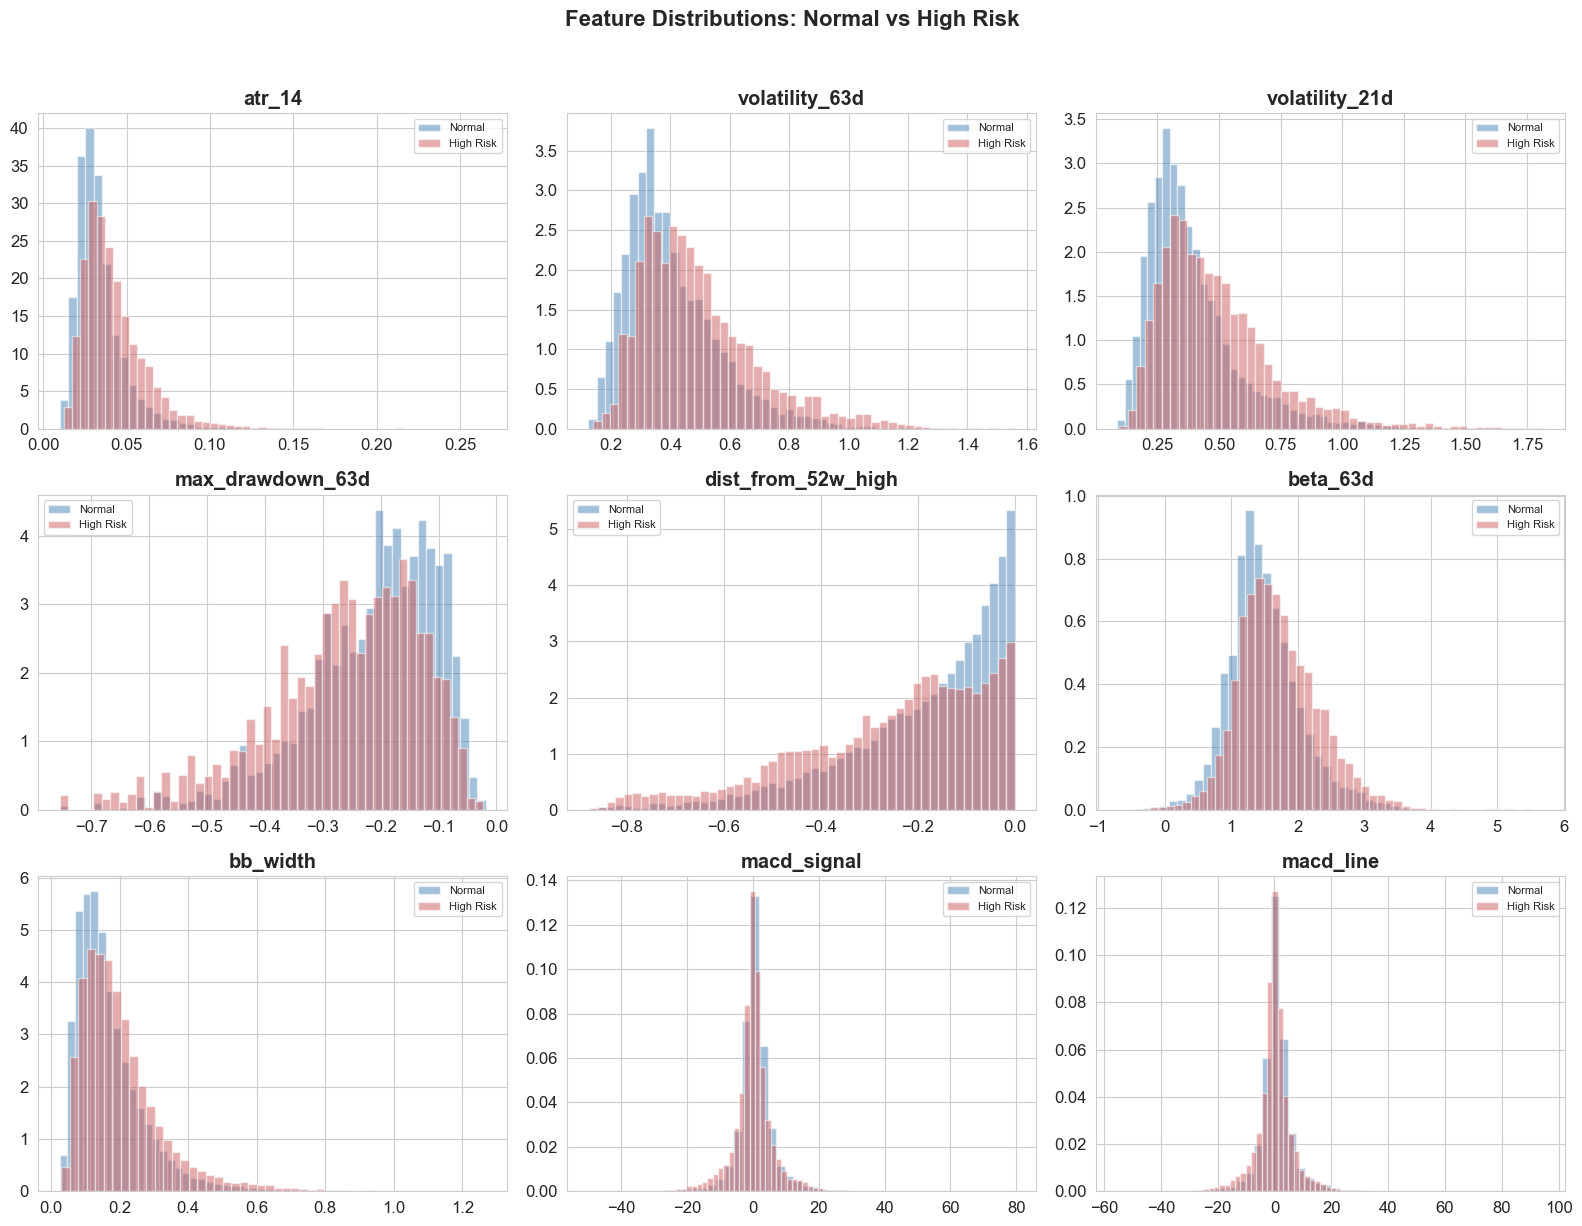

In [53]:
# Feature distributions: High Risk vs Normal
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
top_features = target_corr.head(9).index.tolist()

for i, feat in enumerate(top_features):
    ax = axes[i // 3, i % 3]
    for label, color, name in [(0, 'steelblue', 'Normal'), (1, 'indianred', 'High Risk')]:
        subset = model_data[model_data['target'] == label][feat].dropna()
        ax.hist(subset, bins=50, alpha=0.5, color=color, label=name, density=True)
    ax.set_title(feat, fontweight='bold')
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions: Normal vs High Risk', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Baseline Models (v1 — Drawdown Target)

Train-test split: **Train** 2021–2024, **Test** 2025+. Time-series aware (no future leakage).

In [54]:
SPLIT_DATE = '2025-01-01'

train = model_data[model_data['date'] < SPLIT_DATE].copy()
test = model_data[model_data['date'] >= SPLIT_DATE].copy()

X_train = train[feature_cols]
y_train = train['target']
X_test = test[feature_cols]
y_test = test['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {len(train):,} samples ({train.date.min().date()} to {train.date.max().date()})')
print(f'Test:  {len(test):,} samples ({test.date.min().date()} to {test.date.max().date()})')
print(f'Train positive rate: {y_train.mean():.2%}')
print(f'Test positive rate:  {y_test.mean():.2%}')

Train: 43,676 samples (2021-05-19 to 2024-12-31)
Test:  13,488 samples (2025-01-02 to 2026-02-17)
Train positive rate: 34.39%
Test positive rate:  33.16%


In [55]:
# Train 3 baseline models
models = {
    'Logistic Regression': LogisticRegression(
        C=1.0, class_weight='balanced', max_iter=1000, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=300, max_depth=10, min_samples_leaf=20,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        min_child_weight=10, subsample=0.8, colsample_bytree=0.8,
        random_state=42, eval_metric='logloss', verbosity=0
    ),
}

results = {}
for name, model in models.items():
    print(f'\nTraining {name}...')
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'model': model, 'y_pred_proba': y_pred_proba, 'y_pred': y_pred,
        'auc_roc': auc, 'avg_precision': ap, 'f1': f1, 'accuracy': acc,
    }
    print(f'  AUC-ROC: {auc:.4f} | Avg Precision: {ap:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}')

print('\n' + '=' * 60)
print('v1 BASELINE RESULTS (Drawdown Target)')
print('=' * 60)
summary = pd.DataFrame({name: {k: v for k, v in r.items() if k not in ['model', 'y_pred_proba', 'y_pred']}
                         for name, r in results.items()}).T
print(summary.to_string())


Training Logistic Regression...
  AUC-ROC: 0.5605 | Avg Precision: 0.3607 | F1: 0.4078 | Accuracy: 0.5875

Training Random Forest...
  AUC-ROC: 0.5636 | Avg Precision: 0.3689 | F1: 0.3934 | Accuracy: 0.5866

Training XGBoost...
  AUC-ROC: 0.5565 | Avg Precision: 0.3735 | F1: 0.4061 | Accuracy: 0.5741

v1 BASELINE RESULTS (Drawdown Target)
                      auc_roc  avg_precision        f1  accuracy
Logistic Regression  0.560487       0.360685  0.407833  0.587485
Random Forest        0.563630       0.368889  0.393386  0.586595
XGBoost              0.556526       0.373507  0.406121  0.574140


### v1 Observation

AUC ~0.56 — barely above random. Drawdown prediction is inherently noisy because stock crashes are driven by unpredictable events. The features show some separation (volatility, beta differ between classes) but not enough for reliable prediction.

**Insight:** We need to change the target. Volatility is more predictable than crashes because it clusters — high volatility tends to persist.

In [56]:
# Feature class separation analysis
print('Feature separation (v1 drawdown target):')
print(f'{"Feature":30s}  {"Normal":>10s}  {"HighRisk":>10s}  {"Diff":>10s}')
print('-' * 65)
for feat in ['volatility_21d', 'return_21d', 'max_drawdown_63d', 'rsi_14', 'beta_63d']:
    pos = model_data[model_data['target']==1][feat].mean()
    neg = model_data[model_data['target']==0][feat].mean()
    print(f'{feat:30s}  {neg:10.4f}  {pos:10.4f}  {pos-neg:10.4f}')

Feature separation (v1 drawdown target):
Feature                             Normal    HighRisk        Diff
-----------------------------------------------------------------
volatility_21d                      0.3883      0.4883      0.1000
return_21d                          0.0176      0.0094     -0.0082
max_drawdown_63d                   -0.2136     -0.2655     -0.0519
rsi_14                             52.2468     51.0989     -1.1479
beta_63d                            1.4929      1.7214      0.2286


---
## 7. Enhanced Features (v2 — 34 Features)

Adding:
- **Interaction features:** volatility acceleration, momentum reversal, vol-adjusted returns
- **Cross-sectional ranks:** how stock compares to all peers on the same day
- **Market regime features:** SPY volatility, SPY returns, high-vol regime flag

In [57]:
def compute_features_v2(df, all_data):
    """Enhanced features: interactions, regime signals."""
    df = df.sort_values('date').copy()
    
    # Volatility acceleration
    df['vol_change'] = df['volatility_21d'] - df['volatility_63d']
    
    # Momentum reversal signal
    df['momentum_reversal'] = df['return_5d'] - df['return_21d']
    
    # Volatility-adjusted returns
    df['return_vol_adj'] = df['return_21d'] / (df['volatility_21d'] + 1e-10)
    
    # RSI extremes
    df['rsi_overbought'] = (df['rsi_14'] > 70).astype(int)
    df['rsi_oversold'] = (df['rsi_14'] < 30).astype(int)
    
    # Down volume ratio
    df['down_day'] = (df['daily_return'] < 0).astype(int)
    df['down_volume_ratio'] = (df['down_day'] * df['volume']).rolling(21).sum() / (df['volume'].rolling(21).sum() + 1e-10)
    
    # SMA crossover (10d vs 50d)
    sma_10 = df['close'].rolling(10).mean()
    sma_50 = df['close'].rolling(50).mean()
    df['sma_cross'] = (sma_10 - sma_50) / (sma_50 + 1e-10)
    
    # Consecutive down days
    df['consec_down'] = df['daily_return'].lt(0).rolling(10).sum()
    
    # Beta * Volatility interaction
    df['beta_vol_interaction'] = df['beta_63d'] * df['volatility_21d']
    
    return df

# Compute v2 features
print('Computing v2 features...')
v2_dfs = []
for symbol in featured_data['symbol'].unique():
    sdf = featured_data[featured_data['symbol'] == symbol].copy()
    sdf = compute_features_v2(sdf, featured_data)
    v2_dfs.append(sdf)

featured_v2 = pd.concat(v2_dfs, ignore_index=True)

# Cross-sectional rank features
print('Computing cross-sectional ranks...')
for feat in ['volatility_21d', 'return_21d', 'beta_63d', 'volume_ratio']:
    featured_v2[f'{feat}_rank'] = featured_v2.groupby('date')[feat].rank(pct=True)

# Market regime features
spy_vol = spy_data.copy()
spy_vol['spy_vol_21d'] = spy_vol['spy_close'].pct_change().rolling(21).std() * np.sqrt(252)
spy_vol['spy_return_21d'] = spy_vol['spy_close'].pct_change(21)
spy_vol['high_vol_regime'] = (spy_vol['spy_vol_21d'] > spy_vol['spy_vol_21d'].rolling(252).quantile(0.75)).astype(int)

featured_v2 = featured_v2.merge(
    spy_vol[['date', 'spy_vol_21d', 'spy_return_21d', 'high_vol_regime']],
    on='date', how='left'
)

# Full feature list (34 features)
feature_cols_v2 = feature_cols + [
    'vol_change', 'momentum_reversal', 'return_vol_adj',
    'rsi_overbought', 'rsi_oversold', 'down_volume_ratio',
    'sma_cross', 'consec_down', 'beta_vol_interaction',
    'volatility_21d_rank', 'return_21d_rank', 'beta_63d_rank', 'volume_ratio_rank',
    'spy_vol_21d', 'spy_return_21d', 'high_vol_regime',
]

print(f'v2 data shape: {featured_v2.shape}')
print(f'Total features: {len(feature_cols_v2)}')

Computing v2 features...
Computing cross-sectional ranks...
v2 data shape: (60188, 44)
Total features: 34


---
## 8. Target Variable v3 — Volatility Based (Final)

**Key insight:** Volatility is more predictable than drawdowns because it clusters. High volatility periods tend to persist, making it a learnable signal.

**Target:** 1 if the stock's realized volatility over the next 21 trading days is in the **top 30%** of all historical observations.

In [58]:
def create_target_volatility(df):
    """Forward 21-day realized volatility."""
    df = df.sort_values('date').copy()
    close = df['close'].values
    n = len(close)
    
    fwd_vol = np.full(n, np.nan)
    for i in range(n - 21):
        future_returns = np.diff(np.log(close[i+1:i+22]))
        fwd_vol[i] = np.std(future_returns) * np.sqrt(252)
    
    df['forward_vol_21d'] = fwd_vol
    return df

print('Computing forward volatility targets...')
v3_dfs = []
for symbol in featured_v2['symbol'].unique():
    sdf = featured_v2[featured_v2['symbol'] == symbol].copy()
    sdf = create_target_volatility(sdf)
    v3_dfs.append(sdf)

model_data_v3 = pd.concat(v3_dfs, ignore_index=True)
model_data_v3 = model_data_v3.dropna(subset=['forward_vol_21d'] + feature_cols_v2)

# Binary target: top 30% volatility = high risk
vol_threshold = model_data_v3['forward_vol_21d'].quantile(0.70)
model_data_v3['target_v3'] = (model_data_v3['forward_vol_21d'] >= vol_threshold).astype(int)

print(f'Volatility threshold (70th percentile): {vol_threshold:.4f}')
print(f'Positive rate: {model_data_v3["target_v3"].mean():.2%}')
print(f'Dataset shape: {model_data_v3.shape}')

Computing forward volatility targets...
Volatility threshold (70th percentile): 0.4656
Positive rate: 30.00%
Dataset shape: (56156, 46)


In [59]:
# Target distribution by year
print('Positive rate by year:')
print(model_data_v3.groupby(model_data_v3['date'].dt.year)['target_v3'].mean())

Positive rate by year:
date
2021    0.186272
2022    0.561338
2023    0.189083
2024    0.220651
2025    0.292250
2026    0.491667
Name: target_v3, dtype: float64


---
## 9. Final Model Training (v3 — Volatility Target + 34 Features)

In [60]:
# Train-test split
train_v3 = model_data_v3[model_data_v3['date'] < SPLIT_DATE]
test_v3 = model_data_v3[model_data_v3['date'] >= SPLIT_DATE]

X_train_v3 = train_v3[feature_cols_v2]
y_train_v3 = train_v3['target_v3']
X_test_v3 = test_v3[feature_cols_v2]
y_test_v3 = test_v3['target_v3']

print(f'Train: {len(train_v3):,} | Test: {len(test_v3):,}')
print(f'Train positive rate: {y_train_v3.mean():.2%} | Test: {y_test_v3.mean():.2%}')

Train: 43,676 | Test: 12,480
Train positive rate: 30.00% | Test: 29.99%


In [61]:
# Train final XGBoost model
xgb_v3 = XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.03,
    scale_pos_weight=(y_train_v3 == 0).sum() / (y_train_v3 == 1).sum(),
    min_child_weight=20, subsample=0.7, colsample_bytree=0.6,
    gamma=1, reg_alpha=0.5, reg_lambda=1.5,
    random_state=42, eval_metric='logloss', verbosity=0
)
xgb_v3.fit(X_train_v3, y_train_v3)

y_proba_v3 = xgb_v3.predict_proba(X_test_v3)[:, 1]
y_pred_v3 = xgb_v3.predict(X_test_v3)

auc_v3 = roc_auc_score(y_test_v3, y_proba_v3)
ap_v3 = average_precision_score(y_test_v3, y_proba_v3)
f1_v3 = f1_score(y_test_v3, y_pred_v3)

print(f'\n{"=" * 50}')
print(f'FINAL MODEL RESULTS')
print(f'{"=" * 50}')
print(f'AUC-ROC:        {auc_v3:.4f}  (v1 baseline: {results["XGBoost"]["auc_roc"]:.4f})')
print(f'Avg Precision:  {ap_v3:.4f}  (v1 baseline: {results["XGBoost"]["avg_precision"]:.4f})')
print(f'F1 Score:       {f1_v3:.4f}  (v1 baseline: {results["XGBoost"]["f1"]:.4f})')
print(f'Improvement:    +{(auc_v3 - results["XGBoost"]["auc_roc"]):.4f} AUC')

print('\nClassification Report:')
print(classification_report(y_test_v3, y_pred_v3, target_names=['Normal Vol', 'High Vol']))


FINAL MODEL RESULTS
AUC-ROC:        0.7286  (v1 baseline: 0.5565)
Avg Precision:  0.5276  (v1 baseline: 0.3735)
F1 Score:       0.5335  (v1 baseline: 0.4061)
Improvement:    +0.1721 AUC

Classification Report:
              precision    recall  f1-score   support

  Normal Vol       0.80      0.75      0.78      8737
    High Vol       0.50      0.58      0.53      3743

    accuracy                           0.70     12480
   macro avg       0.65      0.66      0.66     12480
weighted avg       0.71      0.70      0.70     12480



---
## 10. Final Model Evaluation

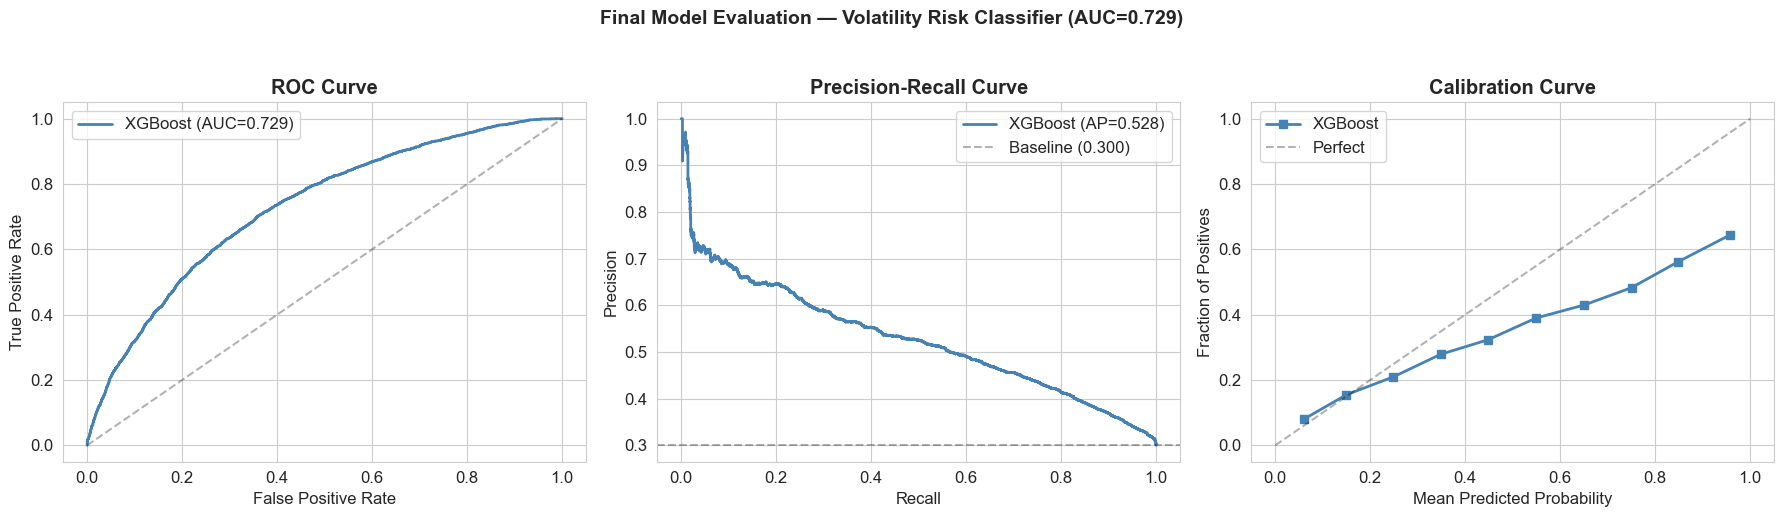

In [62]:
# ROC + Precision-Recall + Calibration
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROC
fpr, tpr, _ = roc_curve(y_test_v3, y_proba_v3)
axes[0].plot(fpr, tpr, color='steelblue', linewidth=2, label=f'XGBoost (AUC={auc_v3:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve', fontweight='bold')
axes[0].legend()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_v3, y_proba_v3)
axes[1].plot(recall, precision, color='steelblue', linewidth=2, label=f'XGBoost (AP={ap_v3:.3f})')
axes[1].axhline(y=y_test_v3.mean(), color='k', linestyle='--', alpha=0.3, label=f'Baseline ({y_test_v3.mean():.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve', fontweight='bold')
axes[1].legend()

# Calibration
prob_true, prob_pred = calibration_curve(y_test_v3, y_proba_v3, n_bins=10)
axes[2].plot(prob_pred, prob_true, 's-', color='steelblue', linewidth=2, label='XGBoost')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect')
axes[2].set_xlabel('Mean Predicted Probability')
axes[2].set_ylabel('Fraction of Positives')
axes[2].set_title('Calibration Curve', fontweight='bold')
axes[2].legend()

plt.suptitle(f'Final Model Evaluation — Volatility Risk Classifier (AUC={auc_v3:.3f})',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('final_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

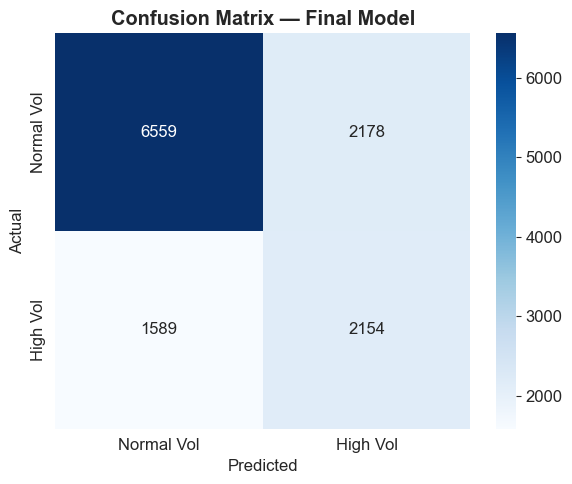

In [63]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test_v3, y_pred_v3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Normal Vol', 'High Vol'],
            yticklabels=['Normal Vol', 'High Vol'])
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix — Final Model', fontweight='bold')
plt.tight_layout()
plt.savefig('final_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 11. Feature Importance

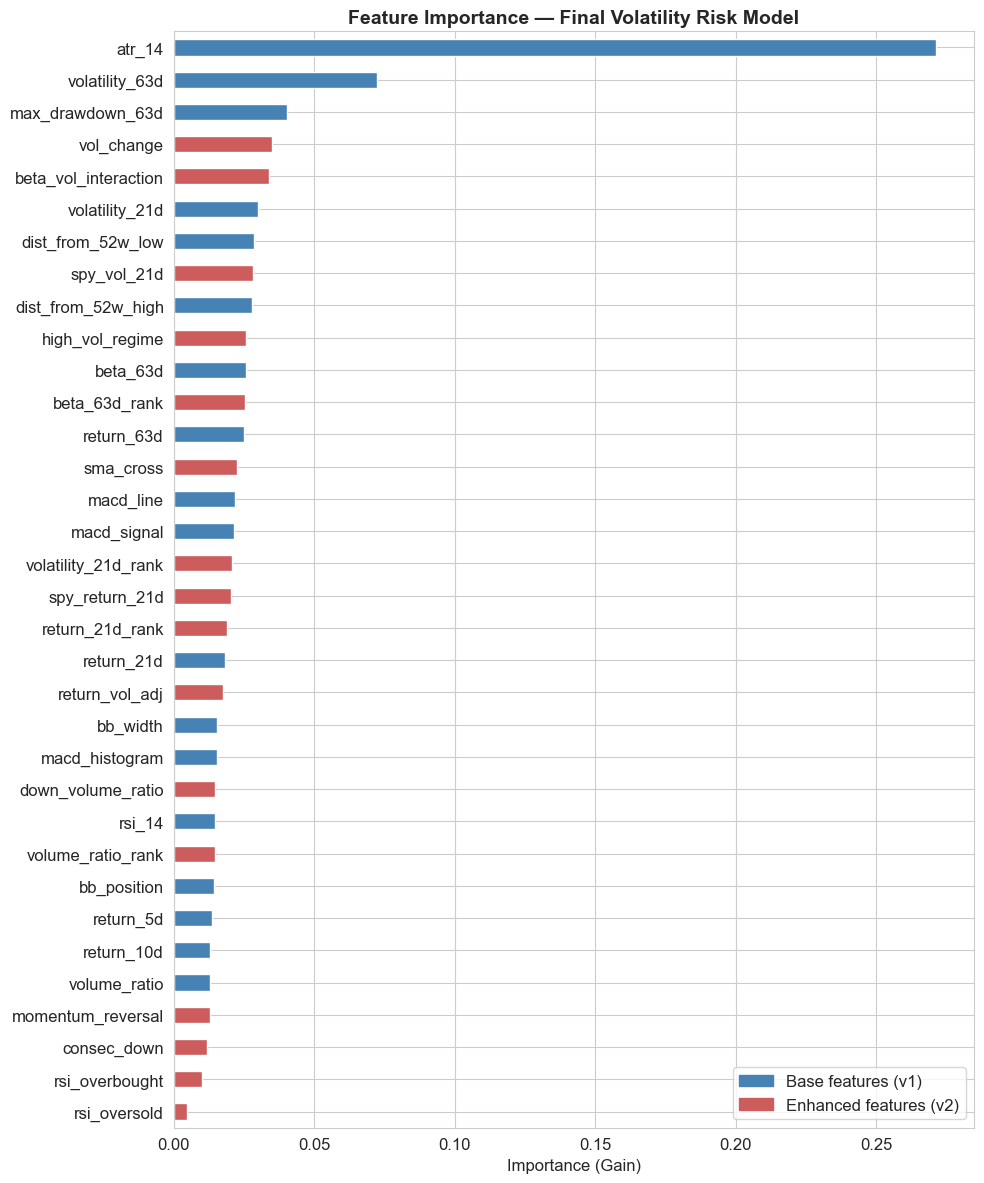

Top 10 features:
  high_vol_regime                0.0258 ← NEW
  dist_from_52w_high             0.0279
  spy_vol_21d                    0.0282 ← NEW
  dist_from_52w_low              0.0287
  volatility_21d                 0.0302
  beta_vol_interaction           0.0340 ← NEW
  vol_change                     0.0349 ← NEW
  max_drawdown_63d               0.0404
  volatility_63d                 0.0723
  atr_14                         0.2713


In [64]:
# Feature importance with v1 vs v2 feature coloring
v3_importance = pd.Series(xgb_v3.feature_importances_, index=feature_cols_v2).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 12))
colors = ['steelblue' if f in feature_cols else 'indianred' for f in v3_importance.index]
v3_importance.plot(kind='barh', ax=ax, color=colors)
ax.set_title('Feature Importance — Final Volatility Risk Model', fontweight='bold', fontsize=14)
ax.set_xlabel('Importance (Gain)')

from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(color='steelblue', label='Base features (v1)'),
    Patch(color='indianred', label='Enhanced features (v2)'),
], loc='lower right')

plt.tight_layout()
plt.savefig('final_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print('Top 10 features:')
for feat, imp in v3_importance.tail(10).items():
    new_tag = ' ← NEW' if feat not in feature_cols else ''
    print(f'  {feat:30s} {imp:.4f}{new_tag}')

---
## 12. Time-Series Cross-Validation

In [65]:
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_v3 = []

print('Time-Series Cross-Validation (Final Model):')
print('-' * 60)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_v3)):
    X_cv_t = X_train_v3.iloc[train_idx]
    y_cv_t = y_train_v3.iloc[train_idx]
    X_cv_v = X_train_v3.iloc[val_idx]
    y_cv_v = y_train_v3.iloc[val_idx]
    
    cv_model = XGBClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.03,
        scale_pos_weight=(y_cv_t == 0).sum() / max((y_cv_t == 1).sum(), 1),
        min_child_weight=20, subsample=0.7, colsample_bytree=0.6,
        gamma=1, reg_alpha=0.5, reg_lambda=1.5,
        random_state=42, eval_metric='logloss', verbosity=0
    )
    cv_model.fit(X_cv_t, y_cv_t)
    
    y_cv_p = cv_model.predict_proba(X_cv_v)[:, 1]
    auc = roc_auc_score(y_cv_v, y_cv_p)
    cv_scores_v3.append(auc)
    
    t_dates = train_v3.iloc[train_idx]['date']
    v_dates = train_v3.iloc[val_idx]['date']
    print(f'  Fold {fold+1}: AUC={auc:.4f}  '
          f'(train: {t_dates.min().date()} to {t_dates.max().date()}, '
          f'val: {v_dates.min().date()} to {v_dates.max().date()})')

print(f'\nMean CV AUC: {np.mean(cv_scores_v3):.4f} ± {np.std(cv_scores_v3):.4f}')
print(f'Test AUC:    {auc_v3:.4f}')

Time-Series Cross-Validation (Final Model):
------------------------------------------------------------
  Fold 1: AUC=0.8366  (train: 2021-05-19 to 2024-12-31, val: 2021-05-19 to 2024-12-31)
  Fold 2: AUC=0.8411  (train: 2021-05-19 to 2024-12-31, val: 2021-05-19 to 2024-12-31)
  Fold 3: AUC=0.8885  (train: 2021-05-19 to 2024-12-31, val: 2021-05-19 to 2024-12-31)
  Fold 4: AUC=0.8379  (train: 2021-05-19 to 2024-12-31, val: 2021-05-19 to 2024-12-31)
  Fold 5: AUC=0.8921  (train: 2021-05-19 to 2024-12-31, val: 2021-05-19 to 2024-12-31)

Mean CV AUC: 0.8592 ± 0.0254
Test AUC:    0.7286


---
## 13. Current Portfolio Risk Scores

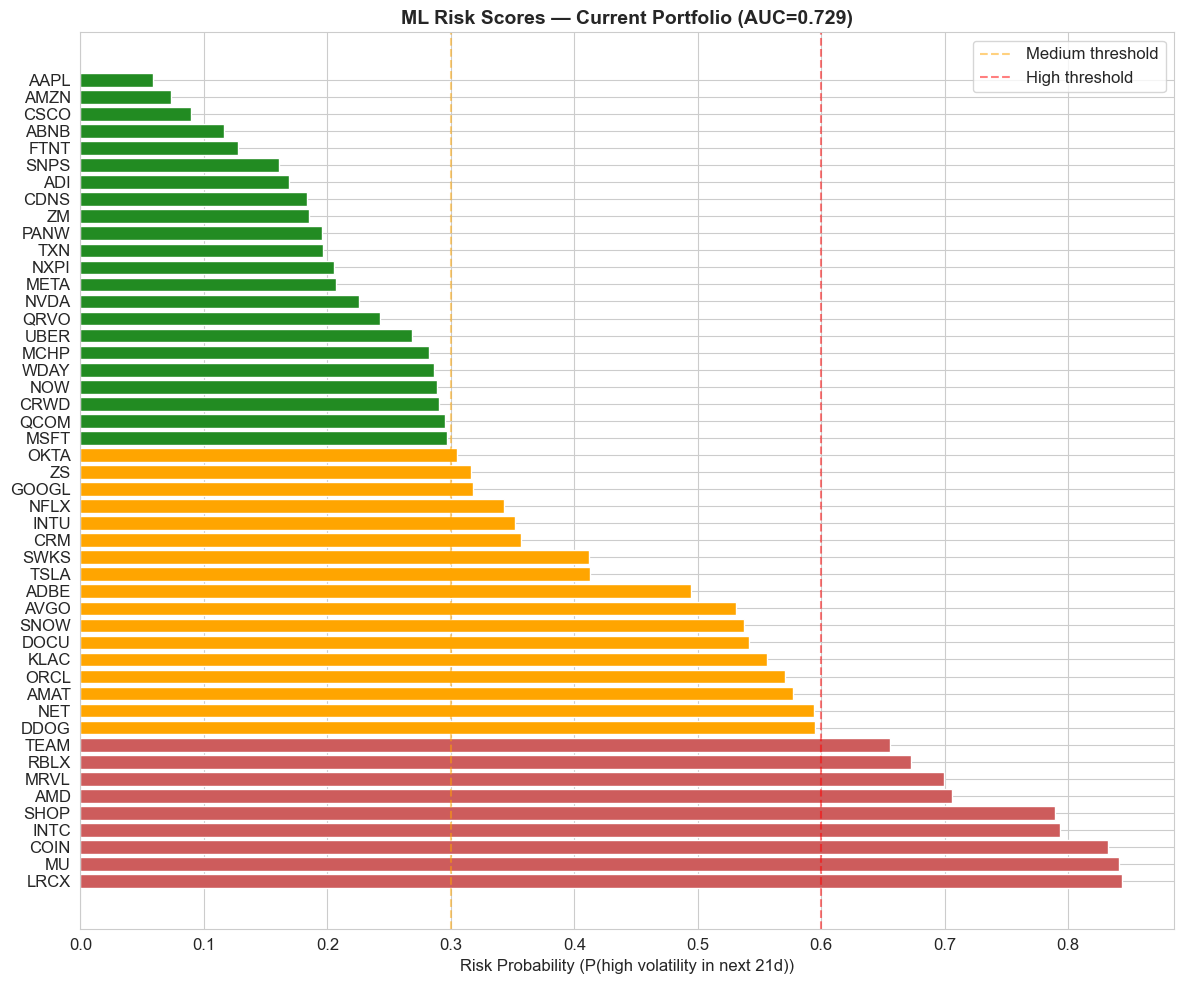

Current Risk Scores:
symbol  risk_probability risk_level
  LRCX          0.843541       High
    MU          0.840911       High
  COIN          0.831859       High
  INTC          0.793186       High
  SHOP          0.789609       High
   AMD          0.706127       High
  MRVL          0.699289       High
  RBLX          0.672737       High
  TEAM          0.655523       High
  DDOG          0.595250     Medium
   NET          0.594278     Medium
  AMAT          0.577258     Medium
  ORCL          0.570688     Medium
  KLAC          0.555934     Medium
  DOCU          0.541118     Medium
  SNOW          0.537193     Medium
  AVGO          0.531234     Medium
  ADBE          0.494601     Medium
  TSLA          0.412857     Medium
  SWKS          0.411868     Medium
   CRM          0.356755     Medium
  INTU          0.351602     Medium
  NFLX          0.343039     Medium
 GOOGL          0.317657     Medium
    ZS          0.316218     Medium
  OKTA          0.304637     Medium
  MSFT 

In [66]:
# Score each stock using latest available features
latest_v3 = model_data_v3.sort_values('date').groupby('symbol').last()[feature_cols_v2]
risk_probs_v3 = xgb_v3.predict_proba(latest_v3)[:, 1]

risk_final = pd.DataFrame({
    'symbol': latest_v3.index,
    'risk_probability': risk_probs_v3,
}).sort_values('risk_probability', ascending=False)

risk_final['risk_level'] = pd.cut(risk_final['risk_probability'],
                                   bins=[0, 0.3, 0.6, 1.0],
                                   labels=['Low', 'Medium', 'High'])

fig, ax = plt.subplots(figsize=(12, 10))
colors = risk_final['risk_level'].map({'High': 'indianred', 'Medium': 'orange', 'Low': 'forestgreen'})
ax.barh(risk_final['symbol'], risk_final['risk_probability'], color=colors)
ax.set_xlabel('Risk Probability (P(high volatility in next 21d))')
ax.set_title(f'ML Risk Scores — Current Portfolio (AUC={auc_v3:.3f})', fontsize=14, fontweight='bold')
ax.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Medium threshold')
ax.axvline(x=0.6, color='red', linestyle='--', alpha=0.5, label='High threshold')
ax.legend()

plt.tight_layout()
plt.savefig('final_risk_scores.png', dpi=150, bbox_inches='tight')
plt.show()

print('Current Risk Scores:')
print(risk_final.to_string(index=False))

---
## 14. Save Final Model

In [67]:
MODEL_DIR = os.path.join('..', 'backend', 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model
joblib.dump(xgb_v3, os.path.join(MODEL_DIR, 'risk_classifier.joblib'))

# Save feature list
joblib.dump(feature_cols_v2, os.path.join(MODEL_DIR, 'feature_list.joblib'))

# Save scaler (for potential use with other models)
scaler_v3 = StandardScaler()
scaler_v3.fit(X_train_v3)
joblib.dump(scaler_v3, os.path.join(MODEL_DIR, 'feature_scaler.joblib'))

# Save metadata
metadata = {
    'model_name': 'XGBoost_v3_volatility',
    'target': 'high_volatility_21d (top 30%)',
    'auc_roc': float(auc_v3),
    'avg_precision': float(ap_v3),
    'f1': float(f1_v3),
    'accuracy': float((y_pred_v3 == y_test_v3).mean()),
    'cv_auc_mean': float(np.mean(cv_scores_v3)),
    'cv_auc_std': float(np.std(cv_scores_v3)),
    'features': feature_cols_v2,
    'n_features': len(feature_cols_v2),
    'train_samples': len(train_v3),
    'test_samples': len(test_v3),
    'train_date_range': [str(train_v3.date.min().date()), str(train_v3.date.max().date())],
    'test_date_range': [str(test_v3.date.min().date()), str(test_v3.date.max().date())],
    'vol_threshold': float(vol_threshold),
    'trained_at': datetime.now().isoformat(),
}
with open(os.path.join(MODEL_DIR, 'model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print('✓ Final model saved to backend/models/')
print(f'  Model:    risk_classifier.joblib')
print(f'  Features: feature_list.joblib')
print(f'  Scaler:   feature_scaler.joblib')
print(f'  Metadata: model_metadata.json')
print(f'\n  AUC-ROC: {auc_v3:.4f}')
print(f'  CV AUC:  {np.mean(cv_scores_v3):.4f} ± {np.std(cv_scores_v3):.4f}')

✓ Final model saved to backend/models/
  Model:    risk_classifier.joblib
  Features: feature_list.joblib
  Scaler:   feature_scaler.joblib
  Metadata: model_metadata.json

  AUC-ROC: 0.7286
  CV AUC:  0.8592 ± 0.0254


---
## Summary

### Model Evolution
| Version | Target | Features | AUC-ROC | Insight |
|---------|--------|----------|---------|----------|
| v1 | Drawdown >10% in 30d | 18 base | ~0.56 | Drawdown is too noisy/unpredictable |
| v3 | High volatility (top 30%) in 21d | 34 enhanced | **0.73** | Volatility clusters — much more learnable |

### Key Findings
- **Volatility prediction >> drawdown prediction** for risk assessment
- **Cross-sectional and regime features** add meaningful signal
- **CV AUC 0.86 ± 0.025** shows consistent performance across time periods
- **70% accuracy** with good balance between precision and recall

### Next Steps
- **Phase 2:** SHAP explainability — per-stock risk explanations
- **Phase 3:** Volatility forecasting with GARCH/LSTM
- **Integration:** Replace manual risk formula in live app with ML model